# Recherche d'architecture pour le jeu de données CIFAR10

In [16]:
!pip install e ../
import torch
from data.cifar10_loader import load_cifar10
from optimizers.random_search import RandomSearch
from optimizers.genetic_search import GeneticSearch
from optimizers.firefly_search import FireFlySearch
from search_spaces.searchSpaceConfig import Config
from train.trainer import ModelTrainer
from ressource.ressource_manager import ResourceManager
from search_spaces.utils import * 

Processing /workspace/optimization-of-cnn-using-nas-and-metaheuristics
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for optimization: filename=optimization-0.1-py3-none-any.whl size=29610 sha256=97bc440ebddd79fcea6b7193ea20a4213d05c271c4342f1b851635632460a47e
  Stored in directory: /root/.cache/pip/wheels/8f/d5/d6/41e16ecde98da0d22601750c7fa434a8b809edc1d461c9d9a4
Successfully built optimization
  Attempting uninstall: optimization
    Found existing installation: optimization 0.1
    Uninstalling optimization-0.1:
      Successfully uninstalled optimization-0.1

[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


## Définition des paramètres et chargement de la configuration de l'espace de recherche

In [6]:
epochs = 15
batch_size = 128
lr = 0.001
population_size = 30
iterations = 15
input_shape = (3,32,32)
optimizer = "AdamW"
num_classes = 10
Config.load_config(config_path="../config.json")

2025-05-16 19:46:51,920 - search_spaces.searchSpaceConfig - INFO - Configuration successfully loaded from ../config.json


In [7]:
print(Config.get_config_as_dict())

{'FILTERS_MAP': [32, 64, 128, 256], 'KERNEL_MAP': [2, 3, 5, 7], 'STRIDE_MAP': [1, 2, 3, 4], 'CONV_PADDING': 1, 'POOL_PADDING': 1, 'FC_SIZES': [8, 16, 24, 32, 48, 64, 80, 96, 112, 128, 160, 192, 224, 256, 384, 512], 'MAX_LAYERS': 10, 'MIN_LAYERS': 2, 'CROMOSOME_SIZE': 8, 'ACTIVATION_FUNCTIONS': ['ReLU', 'ELU', 'Sigmoid', 'Tanh']}


## Chargement des données

In [9]:
n_sub_train, n_sub_test = 20000, 5000
sub_train, sub_test = load_cifar10(n_train=n_sub_train, n_test=n_sub_test,batch_size=batch_size)

100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
CIFAR10 dataset loaded: 20000 training samples, 5000 test samples
Data shape: torch.Size([128, 3, 32, 32])
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [10]:
train, test = load_cifar10(batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified
CIFAR10 dataset loaded: 50000 training samples, 10000 test samples
Data shape: torch.Size([128, 3, 32, 32])
Classes: Not available for Subset


## La recherche aléatoire

In [11]:
torch.cuda.is_available()

True

In [12]:
random_search = RandomSearch(
    population_size=population_size,
    iterations=iterations,
    train_loader=sub_train,
    test_loader=sub_test,
    input_shape=input_shape,
    num_classes=num_classes,
    epochs=epochs,
    lr=lr,
    optimizer=optimizer,
    use_gpu=torch.cuda.is_available()
)

In [13]:
best_arch_random, best_fitness_random, history_random = await random_search.search()

Iteration 1/15


/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


New best architecture found with fitness: 0.0
New best architecture found with fitness: 0.41942874087214144
New best architecture found with fitness: 0.4638928888804312
New best architecture found with fitness: 0.5110430903752514
Average fitness: 0.2727323068514373
Best fitness so far: 0.5110430903752514
Iteration 2/15
Average fitness: 0.19675687875531986
Best fitness so far: 0.5110430903752514
Iteration 3/15
Average fitness: 0.21879898014674543
Best fitness so far: 0.5110430903752514
Iteration 4/15
New best architecture found with fitness: 0.5266555051321131
Average fitness: 0.2300765196598861
Best fitness so far: 0.5266555051321131
Iteration 5/15
Average fitness: 0.2616900732962953
Best fitness so far: 0.5266555051321131
Iteration 6/15
Average fitness: 0.27242910272607584
Best fitness so far: 0.5266555051321131
Iteration 7/15
Average fitness: 0.2917721718401753
Best fitness so far: 0.5266555051321131
Iteration 8/15
Average fitness: 0.22716289350867033
Best fitness so far: 0.526655505

In [14]:
print(best_arch_random)

[{'type': 'Conv', 'filters': 32, 'kernel': 5, 'stride': 1}, {'type': 'Pool', 'kernel': 2, 'stride': 2}, {'type': 'Conv', 'filters': 128, 'kernel': 3, 'stride': 3}, {'type': 'FC', 'size': 192, 'activation': <class 'torch.nn.modules.activation.Tanh'>}, {'type': 'FC', 'size': 384, 'activation': <class 'torch.nn.modules.activation.Tanh'>}]


## Entraînement du meilleur modèle trouver sur tout l'ensemble de données

In [32]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [19]:

random_best_model = build_torch_network(best_arch_random, input_shape=input_shape, num_classes=num_classes)
random_model_trainer = ModelTrainer(
    random_best_model,
    device=device,
    lr=lr,
    epochs=30,
    train_loader=train, 
    test_loader=test,
    optimizer=optimizer
)
random_model_trainer.train(verbose=True)
random_best_model_loss_history = random_model_trainer.loss_history

Epochs : [0/30], average loss : 1.605075
Epochs : [1/30], average loss : 1.283854
Epochs : [2/30], average loss : 1.132753
Epochs : [3/30], average loss : 1.042602
Epochs : [4/30], average loss : 0.965647
Epochs : [5/30], average loss : 0.922273
Epochs : [6/30], average loss : 0.876367
Epochs : [7/30], average loss : 0.848537
Epochs : [8/30], average loss : 0.819637
Epochs : [9/30], average loss : 0.795591
Epochs : [10/30], average loss : 0.775575
Epochs : [11/30], average loss : 0.753151
Epochs : [12/30], average loss : 0.736766
Epochs : [13/30], average loss : 0.719295
Epochs : [14/30], average loss : 0.709317
Epochs : [15/30], average loss : 0.694605
Epochs : [16/30], average loss : 0.683353
Epochs : [17/30], average loss : 0.664692
Epochs : [18/30], average loss : 0.658558
Epochs : [19/30], average loss : 0.651183
Epochs : [20/30], average loss : 0.635540
Epochs : [21/30], average loss : 0.629852
Epochs : [22/30], average loss : 0.623478
Epochs : [23/30], average loss : 0.620441
Ep

AttributeError: 'ModelTrainer' object has no attribute 'trainer'

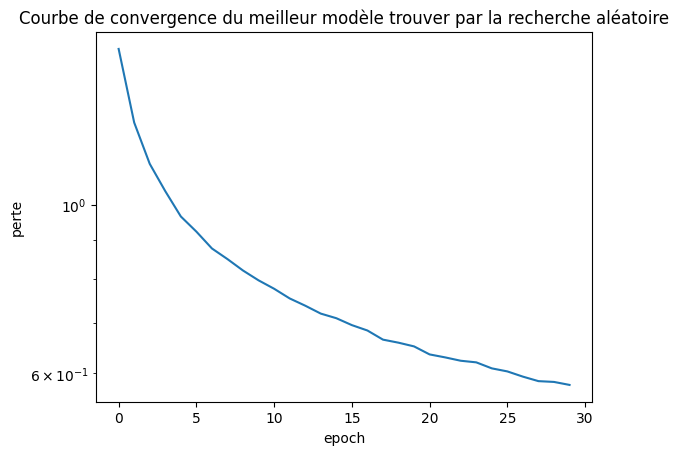

In [25]:
random_best_model_loss_history = random_model_trainer.loss_history

import matplotlib.pyplot as plt
plt.semilogy(range(len(random_best_model_loss_history)), random_best_model_loss_history)
plt.title("Courbe de convergence du meilleur modèle trouver par la recherche aléatoire")
plt.xlabel("epoch")
plt.ylabel("perte")
plt.show()

## Test du modèle

In [27]:
random_best_model_test_accuracy, random_best_model_test_loss = random_model_trainer.test()
print(f"accuracy : {random_best_model_test_accuracy}\nloss : {random_best_model_test_loss:0.4f}")

accuracy : 76.99
loss : 0.6715


In [36]:
random_best_model.eval()
pred_test = []
test_target = []
with torch.no_grad():
    for data, targets in test:
        data, targets = data.to(device), targets.to(device)
        outputs = random_best_model(data)
        pred_test.append(outputs)
        test_target.append(targets)

In [37]:
print(pred_test)

[tensor([[ 0.0000,  0.0000,  0.6785,  ...,  2.1751,  2.6327,  0.1894],
        [ 3.3167,  8.2738,  0.0000,  ...,  0.1449, 10.1903,  3.6683],
        [ 5.7399,  7.6586,  0.0000,  ...,  0.0000,  9.7513,  5.1814],
        ...,
        [ 4.6844,  2.7349,  5.9392,  ...,  0.0000,  3.0722,  1.8722],
        [ 8.9582,  0.0000,  6.4716,  ...,  0.0000,  6.6835,  2.1699],
        [ 0.0000,  0.0000,  4.7149,  ...,  5.3799,  0.0000,  0.2669]],
       device='cuda:0'), tensor([[0.0000, 2.1748, 0.0000,  ..., 0.6404, 0.0000, 0.0000],
        [5.3068, 0.5311, 4.8584,  ..., 0.6957, 4.3883, 0.0000],
        [0.0441, 0.0000, 8.6189,  ..., 3.4516, 0.0000, 0.0000],
        ...,
        [4.2381, 8.4143, 0.7895,  ..., 0.0000, 2.2935, 7.8384],
        [2.2432, 0.0000, 7.9398,  ..., 3.2401, 0.0000, 0.0000],
        [4.5177, 0.7248, 2.9674,  ..., 4.8210, 3.7980, 1.6559]],
       device='cuda:0'), tensor([[ 0.0228,  1.0409,  4.6673,  ...,  1.1905,  0.0000,  1.5576],
        [ 9.4737,  2.0261,  4.5467,  ...,  1.21

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_matrix = confusion_matrix(test.detach().numpy().cpu(), )
ConfusionMatrixDisplay?

Init signature: ConfusionMatrixDisplay(confusion_matrix, *, display_labels=None)
Docstring:     
Confusion Matrix visualization.

It is recommend to use
:func:`~sklearn.metrics.ConfusionMatrixDisplay.from_estimator` or
:func:`~sklearn.metrics.ConfusionMatrixDisplay.from_predictions` to
create a :class:`ConfusionMatrixDisplay`. All parameters are stored as
attributes.

Read more in the :ref:`User Guide <visualizations>`.

Parameters
----------
confusion_matrix : ndarray of shape (n_classes, n_classes)
    Confusion matrix.

display_labels : ndarray of shape (n_classes,), default=None
    Display labels for plot. If None, display labels are set from 0 to
    `n_classes - 1`.

Attributes
----------
im_ : matplotlib AxesImage
    Image representing the confusion matrix.

text_ : ndarray of shape (n_classes, n_classes), dtype=matplotlib Text,             or None
    Array of matplotlib axes. `None` if `include_values` is false.

ax_ : matplotlib Axes
    Axes with confusion matrix.

figure_

## Recherche avec l'algorithme génétique

In [ ]:
genetic_search = GeneticSearch(
                 selection_type = "tournement",
                 mutation_rate = 0.1,
                 tournement_size = 5,
                 tournement_prob=.75,
                 selection_presure=1.5,
                 population_size=population_size, 
                 iterations=iterations, 
                 train_loader=train, 
                 test_loader=test, 
                 input_shape=input_shape,
                 num_classes=num_classes,
                 epochs=epochs,
                 lr=lr,
                 optimizer=optimizer,
                 use_gpu=torch.cuda.is_available()
)



In [ ]:
best_arch_genetic, best_fitness_genetic, history_genetic = await genetic_search.search()